In [59]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from math import exp,sqrt
from scipy import optimize as op

# Data Preprocessing

In [56]:
data = pd.read_csv('./04_cricket_1999to2011.csv')

data = data[['Over','Runs','Total.Out']]
# Nx50 Matrix holding history data 
Runs_wickets = list()


inning = np.zeros(100)
i=0
for d in data.itertuples():
    if d[1]==1 or i==50:
        while i!=50:
            inning[i],inning[i+50] = inning[i-1],inning[50+i-1]
            i+=1
        Runs_wickets.append(inning)
        inning = np.zeros(100)
        i=0
    inning[i],inning[i+50] = inning[i-1]+d[2],d[3]
    i+=1

Runs_wickets = np.array(Runs_wickets)
     


## Match till now, Overs = 30

In [52]:
# Runs and Wickets stored Overwise
X = np.zeros(60)

In [57]:
U,S,V = np.linalg.svd(Runs_wickets)

In [73]:
S

array([4.99426321e+04, 4.34539703e+03, 1.83768235e+03, 1.12498269e+03,
       8.09454845e+02, 7.92403855e+02, 5.95062573e+02, 4.88646306e+02,
       4.03162852e+02, 3.50209977e+02, 3.08280112e+02, 2.71608209e+02,
       2.46508911e+02, 2.23968147e+02, 2.15452899e+02, 2.04000727e+02,
       1.88911366e+02, 1.77861362e+02, 1.68467850e+02, 1.53951735e+02,
       1.42857175e+02, 1.37890403e+02, 1.34672069e+02, 1.32243312e+02,
       1.28713985e+02, 1.21793755e+02, 1.19859856e+02, 1.14016635e+02,
       1.10673594e+02, 1.07366447e+02, 1.04573553e+02, 1.02143875e+02,
       1.00006278e+02, 9.84598642e+01, 9.66025332e+01, 9.59612827e+01,
       9.47416028e+01, 9.38014545e+01, 9.15459584e+01, 8.94841771e+01,
       8.80081414e+01, 8.66953223e+01, 8.50749654e+01, 8.35088327e+01,
       8.26483162e+01, 8.15179922e+01, 8.04410735e+01, 7.93827734e+01,
       7.86400015e+01, 7.72431405e+01, 7.57225776e+01, 7.42333034e+01,
       7.31902818e+01, 7.24253115e+01, 7.04746168e+01, 5.87913921e+01,
      

In [64]:
np.shape(V)

(100, 100)

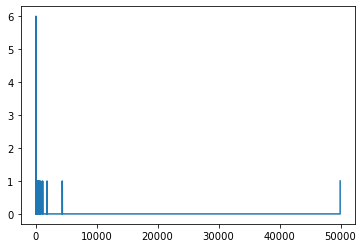

In [72]:
Y = np.bincount(S.astype(int))
plt.plot(Y)
plt.show()

## mRSC